In [1]:
import nrv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

--No graphics will be displayed.


In [2]:
import json

morph = None
with open("./morphology_summary.json", 'r') as f:
    morph = json.load(f)

In [17]:
# Define morphological data based on stats
# Quantified Morphology of the Cervical and Subdiaphragmatic Vagus Nerves of Human, Pig, and Rat (Pelot et al, 2020)
# All in um
cervical_d = morph['cervical']['nerve_diameter_um']['mean']
subdia_d = morph['subdiaphragm']['nerve_diameter_um']['mean']

cervical_fasc_d = morph['cervical']['fascicle_diameter_um']['mean']
subdia_fasc_d = morph['subdiaphragm']['fascicle_diameter_um']['mean']
cervical_perineureum_thk = 0.01292*cervical_fasc_d + 1.367
subdia_perineureum_thk = 0.01292*subdia_fasc_d + 1.367

n_cervical_fasc = 1
n_subdia_fasc = 1

# Define proportions of myelinated vs. unmyelinated fibers
# Influence of Cholecystokinin-8 on Compound Nerve Action Potentials from Ventral Gastric Vagus in Rats (Mirza et al, 2018)
prop_myelinated = 0.28  # A/B fibres
prop_unmyelinated = 1 - prop_myelinated # C fibres

# Since we can only do one nerve and can't change the diameter, use the mean
# nerve_diameter = np.mean([cervical_d, subdia_d])
# fasc_diameter = np.mean([cervical_fasc_d, subdia_fasc_d])
# perineureum_thk = np.mean([cervical_perineureum_thk, subdia_perineureum_thk])

# Since we can only do one nerve and can't change the diameter, use the larger nerve (cervical)
nerve_diameter = np.max([cervical_d, subdia_d])
fasc_diameter = np.max([cervical_fasc_d, subdia_fasc_d])
perineureum_thk = np.max([cervical_perineureum_thk, subdia_perineureum_thk])

NRV INFO: On 500 axons to generate, there are 140 Myelinated and 360 Unmyelinated
NRV INFO: Axon packing initiated. This might take a while...


100%|██████████| 20000/20000 [01:02<00:00, 322.58it/s]


NRV INFO: Packing done!


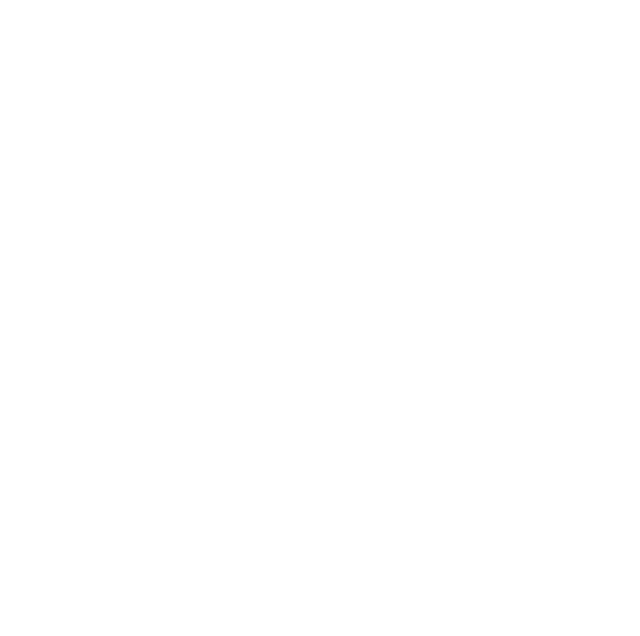

In [27]:
id_map = {}

# Initialize nerve
nerve = nrv.nerve(name='Rat Vagus Nerve', length=100e3, diameter=nerve_diameter, Outer_D=0.005*nerve_diameter, ID=len(id_map))
id_map[len(id_map)] = "Rat Vagus Nerve"

# Define axon properties
def add_fascicles_to_nerve(nerve: nrv.nerve, diameters, prop_unmyel, names, id_map, n_axons):
    for i, diameter in enumerate(diameters):
        # Add fascicle
        fascicle = nrv.fascicle(diameter, len(id_map))
        id_map[len(id_map)] = names[i]

        nerve.add_fascicle(fascicle, y=0, z=0)
        
        axons_diameters, axons_type, M_diam_list, U_diam_list = nrv.create_axon_population(n_axons, percent_unmyel=prop_unmyel, M_stat="Ochoa_M", U_stat="Ochoa_U",)
        fascicle.fill_with_population(axons_diameters, axons_type)
        fascicle.fit_population_to_size()

        
        
# Add fascicles to nerve for cervical section
fascicle_diameters = [fasc_diameter,]
n_axons = 500
names = [f"Fascicle {i}" for i in range(0, len(fascicle_diameters))]
add_fascicles_to_nerve(nerve, fascicle_diameters, prop_unmyelinated, names, id_map, n_axons)

# Add axons to nerve for subdiaphragmatic section
# add_fascicles_to_nerve(nerve, subdiaphragmatic_fascicle_diameters, 50, n_fibers=200)

Text(0, 0.5, 'y-axis (µm)')

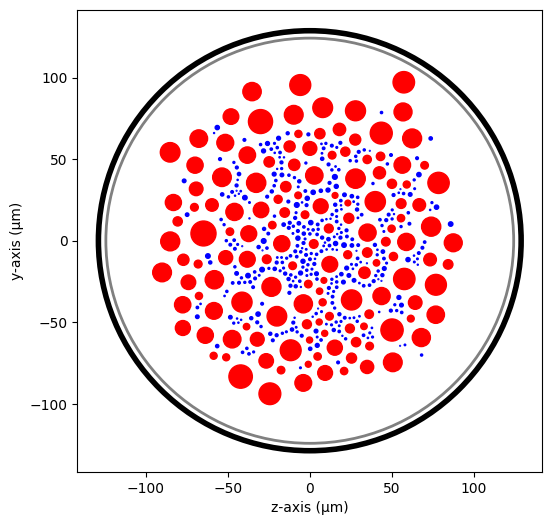

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
nerve.plot(ax)
ax.set_xlabel("z-axis (µm)")
ax.set_ylabel("y-axis (µm)")


Text(0, 0.5, 'y-axis (µm)')

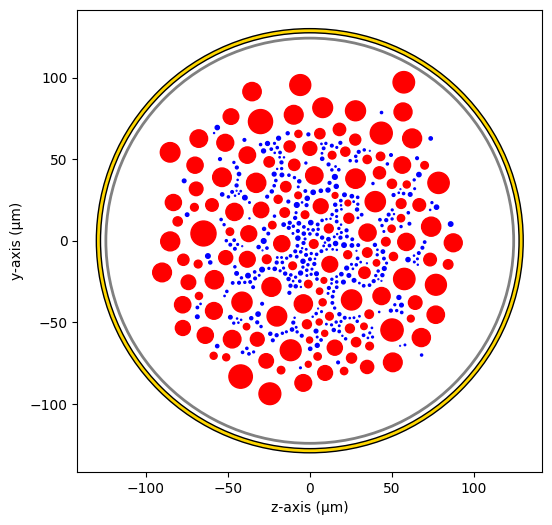

In [29]:
stimulation = nrv.stimulus()
stimulation.pulse(0, 0.1, 1)

extra_stim_cuff = nrv.FEM_stimulation(endo_mat="endoneurium_ranck", #endoneurium conductivity
                                 peri_mat="perineurium",            #perineurium conductivity
                                 epi_mat="epineurium",              #epineurium conductivity
                                 ext_mat="saline")                  #saline solution conductivity

contact_length = 1000         # length (width) of the cuff contact, in um
contact_thickness = 100       # thickness of the contact, in um
insulator_length = 1500       # length (width) of the cuff insulator, on top of the contact
insulator_thickness = 500     # thickness of the in insulator
x_center = 50e3       # x-position of the cuff

stim_cuff = nrv.CUFF_electrode('CUFF', contact_length=contact_length,
    contact_thickness=contact_thickness, insulator_length=insulator_length,
    insulator_thickness=insulator_thickness, x_center=x_center)

extra_stim_cuff.add_electrode(stim_cuff, stimulation)

nerve.attach_extracellular_stimulation(extra_stim_cuff)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
nerve.plot(ax)
ax.set_xlabel("z-axis (µm)")
ax.set_ylabel("y-axis (µm)")


In [30]:
import itertools


pulse_widths = np.array([0.025, 0.05, 0.1, 0.2, 0.5, 1, 2, 5]) # ms
# assume pulse off-time = pulse on-time
max_frequency_pw = [1/(2*pw/1e3) for pw in pulse_widths] # Hz

currents = np.arange(0.1, 3.1, 0.1) # mA

frequencies_pw = np.array([np.linspace(0, max_f, 5)[1:] for max_f in max_frequency_pw])

pw_freq_combinations = [
    (pw, freq) for pw, freqs in zip(pulse_widths, frequencies_pw) for freq in freqs
]

pw_freq_current_combinations = list(itertools.product(pw_freq_combinations, currents))
pw_freq_current_combinations = [(xi, yi, zi) for ((xi, yi), zi) in pw_freq_current_combinations]
search_space = np.array(pw_freq_current_combinations) # [pw, freq, current] in each row

[2.5e-02 5.0e+03 1.1e+00]


Text(0, 0.5, 'Current (mA)')

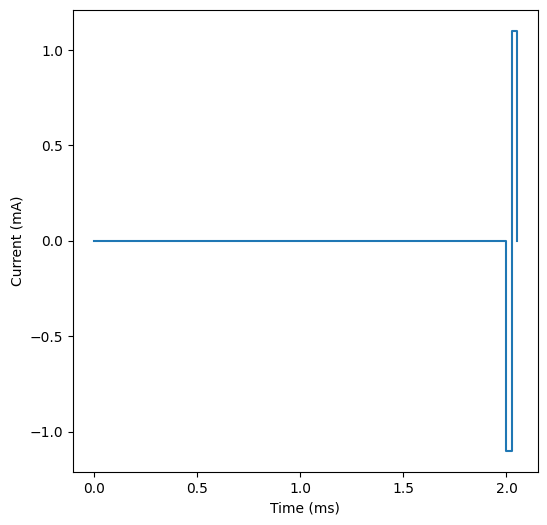

In [31]:
test_params = search_space[10, :]
print(test_params)

# Define asymmetrical square waveform
def asymmetric_square(self, start, duration, t_neg, t_pos, t_off, amplitude, offset, anod_first=False):
    """
    Create a repetitive (periodic) asymmetric square waveform

    Parameters
    ----------
    start       : float
        starting time of the waveform, in ms
    duration    : float
        duration of the waveform, in ms
    t_on        : float
        time the waveform stays at the amplitude value, in ms
    t_off       : float
        time the waveform stays at the offset value, in ms
    amplitude   : float
        amplitude of the waveform, in uA
    offset      : float
        offset current of the waveform, in uA, by default set to 0
    anod_first  : bool
        if True, the waveform starts with a negative pulse
    """

    # Calculate the number of points for t_on and t_off
    dt = 1 / (1000 * (t_pos + t_neg + t_off))  # Sampling period, assuming 1000 samples per ms for the finest resolution
    num_pos_points = int(np.round(t_pos / dt))
    num_neg_points = int(np.round(t_neg / dt))
    num_off_points = int(np.round(t_off / dt))
    # Generate one period of the waveform
    s_pos = np.ones(num_pos_points)*amplitude + offset
    s_neg = np.ones(num_neg_points)*(-amplitude) + offset
    s_off = np.zeros(num_off_points) + offset
    if anod_first:
        s_pos *= -1
        s_neg *= -1

    # Concatenate one period
    s_period = np.concatenate((s_neg, s_pos, s_off))
    t_period = np.arange(1, (num_neg_points + num_pos_points + num_off_points) * dt, dt)
    
    # Calculate the number of periods
    num_periods = int(np.round(duration / (t_pos + t_neg + t_off)))

    # Create the full waveform by repeating the period
    s = np.tile(s_period, num_periods)
    t = np.arange(0, len(s) * dt, dt)
        
    # Adjust to the specified start time
    t += start
    
    self.concatenate(s, t, t_shift=start)

nrv.stimulus.asymmetric_square = asymmetric_square

pulse_train = nrv.stimulus()
t_on = test_params[0]
t_off = 1000/(test_params[1]) - t_on
# pulse_train.asymmetric_square(0, 10, t_on, t_off, test_params[2], 0)
duration = 0.15 * 1000
# pulse_train.asymmetric_square(2, 10, t_on, 0, t_off, test_params[2], 0)
pulse_train.biphasic_pulse(2, test_params[2], t_on, test_params[2], 0,)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
pulse_train.plot(ax)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Current (mA)")


In [32]:
nerve.save_results = False
nerve.return_parameters_only = False
nerve.verbose = True
nerve_results = nerve.simulate(t_sim=1, postproc_script = "AP_detection")

NRV INFO: Starting nerve simulation
NRV INFO: ...computing electrodes footprint
PLC Error:  A segment and a facet intersect at point (50743.6,21.2045,-622.29).
  Segment: [5318,5317] #-1 (0)
  Facet:   [2104,2105,4526] #17


Error   : HXT 3D mesh failed


Exception: HXT 3D mesh failed

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
nerve_results.plot_recruited_fibers(ax)
ax.set_xlabel("y-axis (µm)")
ax.set_ylabel("z-axis (µm)")